<div >
<img src = "../banner.jpg" />
</div>

# Bagging 

## Recap trees

In [1]:
#Cargar librerías 
require("pacman")
p_load(tidyverse,rpart,caret)


#Leer los datos 
credit <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/blob/main/credit_class.rds?raw=true"))

#mutación de factores
credit <- credit %>% mutate(Default=factor(Default,levels=c(0,1),labels=c("No","Si")),
                          history=factor(history,levels=c("good","poor","terrible"),labels=c("buena","mala","terrible")),
                          foreign=factor(foreign,levels=c("foreign","german"),labels=c("extranjero","aleman")),
                          purpose=factor(purpose,levels=c("newcar","usedcar","goods/repair","edu", "biz" ),labels=c("auto_nuevo","auto_usado","bienes","educacion","negocios")))         

credit <- credit  %>% mutate(Default=relevel(Default,ref="Si"))

Loading required package: pacman



In [2]:
head(credit)

,Default,duration,amount,installment,age,history,purpose,foreign,rent
,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,No,6,1169,4,67,terrible,bienes,extranjero,FALSE
2,Si,48,5951,2,22,mala,bienes,extranjero,FALSE
3,No,12,2096,2,49,terrible,educacion,extranjero,FALSE
4,No,42,7882,2,45,mala,bienes,extranjero,FALSE
5,Si,24,4870,3,53,mala,auto_nuevo,extranjero,FALSE
6,No,36,9055,2,35,mala,educacion,extranjero,FALSE


### División de la muestra

- El objetivo es predecir bien fuera de muestra

- No queremos sobreajustar
  

In [3]:
set.seed(1011)
inTrain <- createDataPartition(
  y = credit$Default,## La variable dependiente u objetivo 
  p = .7, ## Usamos 70%  de los datos en el conjunto de entrenamiento 
  list = FALSE)


train <- credit[ inTrain,]
test  <- credit[-inTrain,]

In [4]:
table(train$Default)


 Si  No 
210 490 

In [5]:
table(test$Default)


 Si  No 
 90 210 

<div>
<img src="figures/tree2.png" width="800"/>
</div>

In [6]:
arbol <- rpart(Default~duration+amount+installment+age+
                       history+purpose+foreign+rent, 
                        data    = train,
                       method = "class")

arbol

n= 700 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 700 210 No (0.3000000 0.7000000)  
    2) history=buena 58  23 Si (0.6034483 0.3965517)  
      4) age>=49 7   0 Si (1.0000000 0.0000000) *
      5) age< 49 51  23 Si (0.5490196 0.4509804)  
       10) rent=TRUE 12   2 Si (0.8333333 0.1666667) *
       11) rent=FALSE 39  18 No (0.4615385 0.5384615)  
         22) amount< 2301.5 18   6 Si (0.6666667 0.3333333) *
         23) amount>=2301.5 21   6 No (0.2857143 0.7142857) *
    3) history=mala,terrible 642 175 No (0.2725857 0.7274143)  
      6) history=mala 448 145 No (0.3236607 0.6763393)  
       12) amount>=7973 33  14 Si (0.5757576 0.4242424)  
         24) duration< 25.5 8   1 Si (0.8750000 0.1250000) *
         25) duration>=25.5 25  12 No (0.4800000 0.5200000)  
           50) age< 29 12   4 Si (0.6666667 0.3333333) *
           51) age>=29 13   4 No (0.3076923 0.6923077) *
       13) amount< 7973 415 126 No (0.3036145 0.6963855)  
         26)

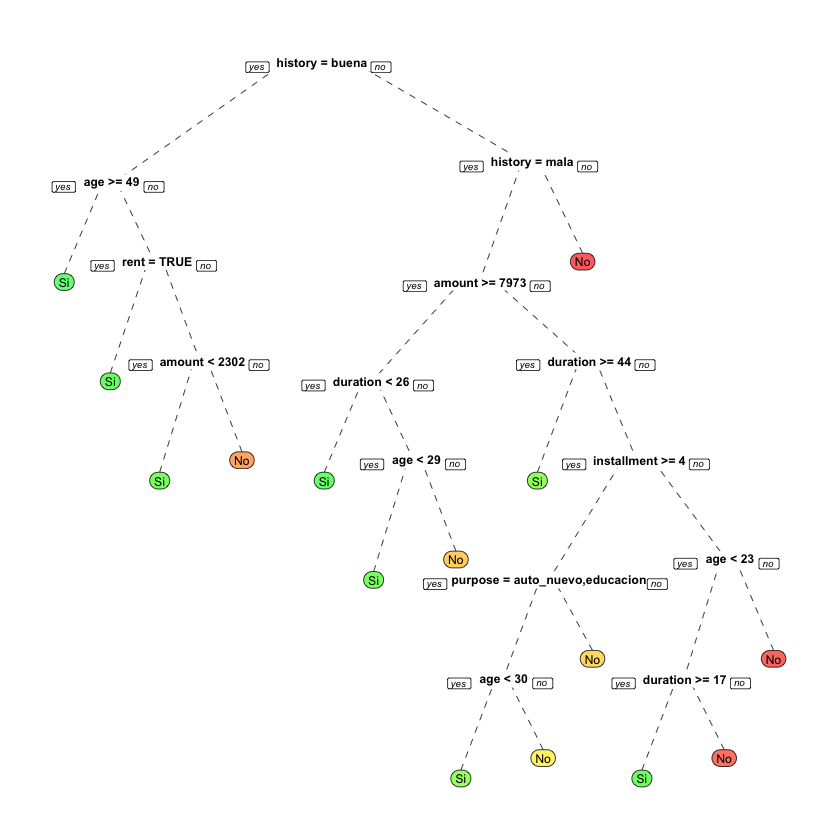

In [7]:
p_load(rpart.plot)
prp(arbol, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,box.palette = "-RdYlGn")

In [8]:
p_load(Metrics)

default<- ifelse(test$Default=="Si",1,0) #númerico

pred_prob <- predict(arbol, newdata = test, type = "prob")    ## Prob predicha

aucval_arbol <- Metrics::auc(actual = default,predicted = pred_prob[,1])

aucval_arbol

[1] 0.643836

## Coding intuition bagging

<div>
<img src="figures/bagged.png" width="800"/>
</div>

- Obtenemos muchos árboles de diferentes *pseudo-muestras* de boostrapp

- Promediamos sobre conjuntos, estos conjuntos de datos  que pueden incluir observaciones varias veces o no incluirlas en absoluto. 

- Esto debería resultar en menos variación $\rightarrow$ Más robustos.

- Perdemos interpretabilidad. Una colección de árboles no es tan fácil de ver como un solo árbol de decisión. 

## Bosques ``from scratch"

- Construyamos  50 árboles diferentes basados en 50 pseudo-muestras  CON reemplazo. 

In [9]:
### Bootstraped samples
set.seed(1011)

B<-500

modelo   <- list()
pred <- list()
aucval <- vector()

for(i in 1:B){
        
    db_sample<- sample_frac(train,size=1,replace=TRUE) #takes a sample with replacement of the same size of the original sample (1 or 100%)
        
    modelo[[i]] <- rpart(Default~duration+amount+installment+age+
                       history+purpose+foreign+rent, 
                        data    =       db_sample,
                       method = "class")
    pred[[i]] <- predict(modelo[[i]], newdata = test, type = "prob")    ## Prob predicha

    aucval[i] <- Metrics::auc(actual = default,predicted = pred[[i]][,1])

    }

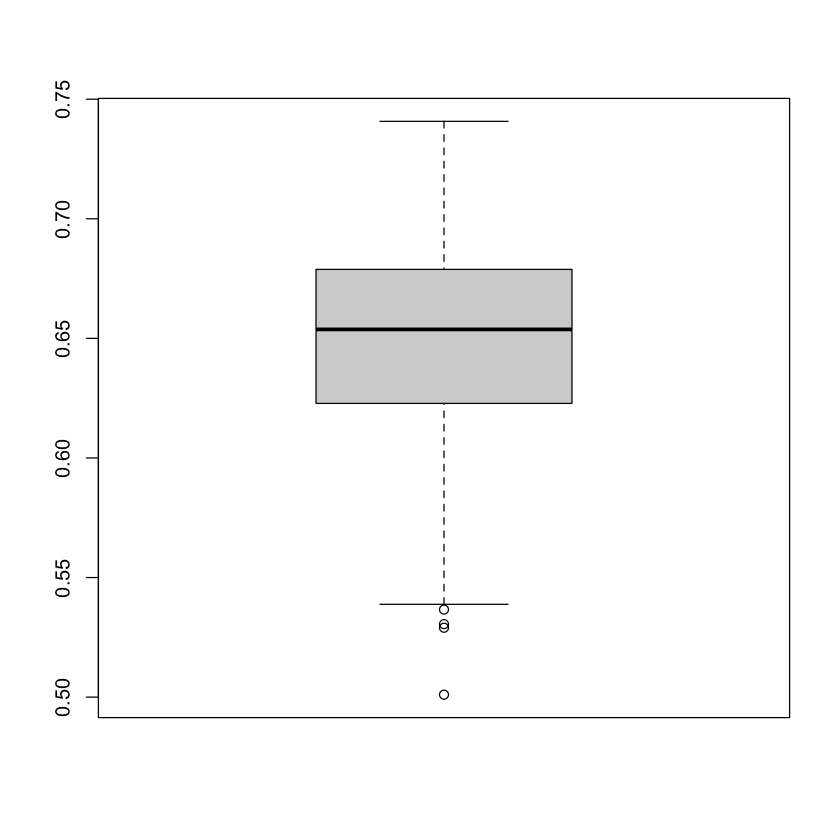

In [10]:
boxplot(aucval)

In [11]:
mean(aucval)

[1] 0.6506412

In [12]:
p_load(ipred) # una de las tantas para hacer bagging
set.seed(1011)

bagged_tree<- bagging(Default~duration+amount+installment+age+
                       history+purpose+foreign+rent, 
                        data    = train, nbagg = 50)

bagged_pred <- predict(bagged_tree,
                       newdata = test, type="prob")

In [13]:
aucval_ipred <- Metrics::auc(actual = default,predicted =bagged_pred[,1])
aucval_ipred

[1] 0.7743651

# Random Forests

In [14]:
fiveStats <- function(...) c(twoClassSummary(...), defaultSummary(...))
ctrl<- trainControl(method = "cv",
                     number = 5,
                     summaryFunction = fiveStats,
                     classProbs = TRUE,
                     verbose=FALSE,
                     savePredictions = T)


In [15]:
p_load(randomForest)


set.seed(1011)
forest <- train(Default~duration+amount+installment+age+
                       history+purpose+foreign+rent, 
  data = train, 
  method = "rf",
  trControl = ctrl,
  metric="Accuracy",
)

In [16]:
forest

Random Forest 

700 samples
  8 predictor
  2 classes: 'Si', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 560, 560, 560, 560 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec       Accuracy   Kappa     
   2    0.6548834  0.0952381  0.9755102  0.7114286  0.09283734
   7    0.6436103  0.2571429  0.8632653  0.6814286  0.13657792
  13    0.6370019  0.2761905  0.8387755  0.6700000  0.12959359

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

## Hiperparámetros

### Parámetros vs hiperparámetros

- Los parámetros del modelo son cosas que se generan como parte del proceso de modelado. Estos pueden ser cosas como los coeficientes de un modelo lineal o, en el caso de un modelo de `rpart`, el número de divisiones en el árbol final o el número total de hojas.

- Los hiperparámetros (a veces llamados metaparámetros) representan información que se proporciona en forma de argumento antes de la llamada al método para generar resultados. Es posible que estos parámetros no sean algo que uno pueda configurar inteligentemente sin experimentar.

https://topepo.github.io/caret/train-models-by-tag.html#random-forest

In [17]:
sqrt(ncol(train)-1) #la raiz cuadrada del numero de predictores

[1] 2.828427

In [18]:
#mtry_grid <- expand.grid(mtry = seq(1, ceiling(ncol(train)-1), 1)) #Randomly Selected Predictors)
mtry_grid<-expand.grid(mtry =c(8,10,12))

In [19]:
set.seed(1011)
bosque <- train(Default~duration+amount+installment+age+
                       history+purpose+foreign+rent, 
  data = train, 
  method = "rf",
  trControl = ctrl,
  metric="Accuracy",
  tuneGrid = mtry_grid,
  ntree=1000)
bosque

Random Forest 

700 samples
  8 predictor
  2 classes: 'Si', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 560, 560, 560, 560 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec       Accuracy   Kappa    
   8    0.6422255  0.2666667  0.8591837  0.6814286  0.1413059
  10    0.6424198  0.2761905  0.8530612  0.6800000  0.1459046
  12    0.6378766  0.2666667  0.8530612  0.6771429  0.1361449

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 8.

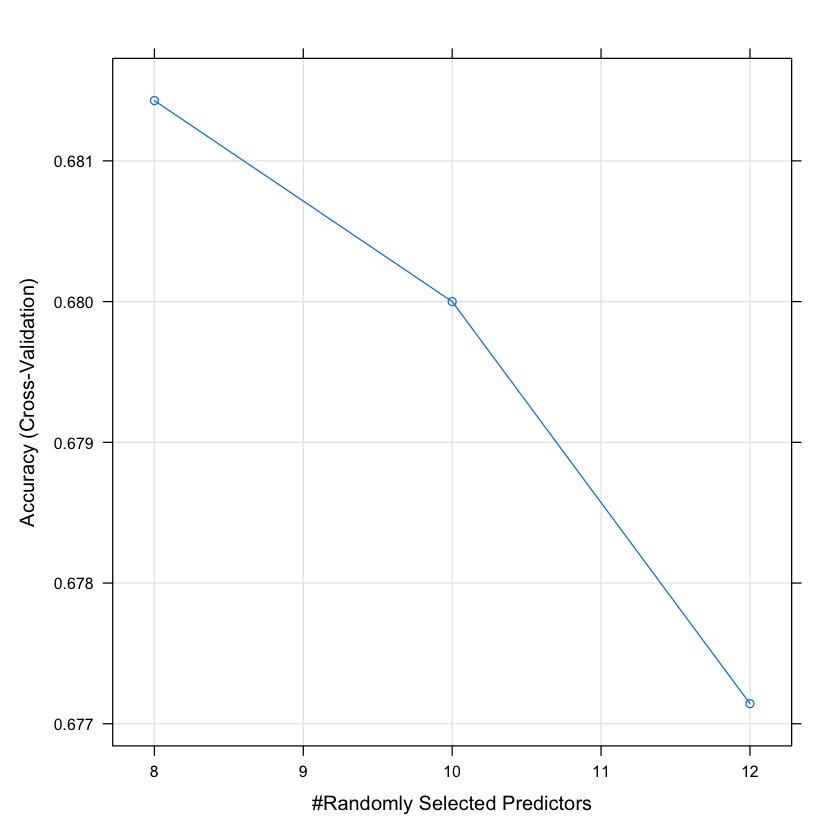

In [20]:
plot(bosque)

In [21]:
bosque$finalModel


Call:
 randomForest(x = x, y = y, ntree = 1000, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 8

        OOB estimate of  error rate: 32.29%
Confusion matrix:
   Si  No class.error
Si 63 147   0.7000000
No 79 411   0.1612245

In [22]:
bosque_pred <- predict(bosque, newdata = test, type="raw")
confusionMatrix(data = bosque_pred, reference = test$Default) #. The idea is that a useful model should do better than you could do by always predicting the most common class. 

Confusion Matrix and Statistics

          Reference
Prediction  Si  No
        Si  34  21
        No  56 189
                                        
               Accuracy : 0.7433        
                 95% CI : (0.69, 0.7918)
    No Information Rate : 0.7           
    P-Value [Acc > NIR] : 0.0560757     
                                        
                  Kappa : 0.3125        
                                        
 Mcnemar's Test P-Value : 0.0001068     
                                        
            Sensitivity : 0.3778        
            Specificity : 0.9000        
         Pos Pred Value : 0.6182        
         Neg Pred Value : 0.7714        
             Prevalence : 0.3000        
         Detection Rate : 0.1133        
   Detection Prevalence : 0.1833        
      Balanced Accuracy : 0.6389        
                                        
       'Positive' Class : Si            
                                        

### Variable Importance

Random Forest: from the R package: “For each tree, the prediction accuracy on the out-of-bag portion of the data is recorded. Then the same is done after permuting each predictor variable. The difference between the two accuracies are then averaged over all trees, and normalized by the standard error. For regression, the MSE is computed on the out-of-bag data for each tree, and then the same computed after permuting a variable. The differences are averaged and normalized by the standard error. If the standard error is equal to 0 for a variable, the division is not done.”

In [23]:
varImp(bosque,scale=TRUE)

rf variable importance

                  Overall
amount            100.000
age                71.816
duration           48.761
installment        17.790
historyterrible    10.684
purposebienes       9.772
historymala         8.676
purposenegocios     4.745
rentFALSE           4.438
rentTRUE            4.349
purposeeducacion    4.059
purposeauto_usado   3.901
foreignaleman       0.000

# Boosted Trees
## ADA boosting

<div>
<img src="figures/adaboost.png" width="800"/>
</div>

In [24]:
#https://topepo.github.io/caret/train-models-by-tag.html#boosting
p_load(fastAdaboost)

M_grid<- expand.grid(nIter=c(10,50,100),method="adaboost")
M_grid


nIter,method
<dbl>,<fct>
10,adaboost
50,adaboost
100,adaboost


In [25]:
set.seed(1011)
adaboost_res <- train(Default~duration+amount+installment+age+
                       history+purpose+foreign+rent,
  data = train, 
  method = "adaboost", 
  trControl = ctrl,
  metric = "Accuracy",
  tuneGrid = M_grid
)
                    
adaboost_res

AdaBoost Classification Trees 

700 samples
  8 predictor
  2 classes: 'Si', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 560, 560, 560, 560 
Resampling results across tuning parameters:

  nIter  ROC        Sens       Spec       Accuracy   Kappa     
   10    0.5236152  0.3714286  0.7632653  0.6457143  0.13791597
   50    0.5223518  0.2238095  0.8591837  0.6685714  0.09623181
  100    0.5100826  0.2095238  0.8755102  0.6757143  0.09904171

Tuning parameter 'method' was held constant at a value of adaboost
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were nIter = 100 and method = adaboost.

In [26]:
pred_ada<-predict(adaboost_res,test)
confusionMatrix(pred_ada,test$Default)

Confusion Matrix and Statistics

          Reference
Prediction  Si  No
        Si  26  11
        No  64 199
                                        
               Accuracy : 0.75          
                 95% CI : (0.697, 0.798)
    No Information Rate : 0.7           
    P-Value [Acc > NIR] : 0.03224       
                                        
                  Kappa : 0.2844        
                                        
 Mcnemar's Test P-Value : 1.92e-09      
                                        
            Sensitivity : 0.28889       
            Specificity : 0.94762       
         Pos Pred Value : 0.70270       
         Neg Pred Value : 0.75665       
             Prevalence : 0.30000       
         Detection Rate : 0.08667       
   Detection Prevalence : 0.12333       
      Balanced Accuracy : 0.61825       
                                        
       'Positive' Class : Si            
                                        

# Traditional GBM

In [27]:
p_load(gbm)


grid_gbm<-expand.grid(n.trees=c(200,300,500),interaction.depth=c(1,2,3),shrinkage=c(0.01,0.001),n.minobsinnode
=c(10,30))
#n.trees (# Boosting Iterations)
#interaction.depth (Max Tree Depth)
#shrinkage (Shrinkage)
# n.minobsinnode (Min. Terminal Node Size) 

grid_gbm

n.trees,interaction.depth,shrinkage,n.minobsinnode
<dbl>,<dbl>,<dbl>,<dbl>
200,1,0.010,10
300,1,0.010,10
500,1,0.010,10
200,2,0.010,10
300,2,0.010,10
500,2,0.010,10
200,3,0.010,10
300,3,0.010,10
500,3,0.010,10


In [28]:
set.seed(1011)
gbm_res <- train(Default~duration+amount+installment+age+
                       history+purpose+foreign+rent,
  data = train, 
  method = "gbm", 
  trControl = ctrl,
  tuneGrid=grid_gbm,
  metric = "Accuracy"
)            



Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2216             nan     0.0010    0.0000
     2        1.2215             nan     0.0010    0.0000
     3        1.2215             nan     0.0010    0.0000
     4        1.2214             nan     0.0010    0.0000
     5        1.2213             nan     0.0010    0.0000
     6        1.2212             nan     0.0010   -0.0000
     7        1.2211             nan     0.0010    0.0000
     8        1.2211             nan     0.0010    0.0000
     9        1.2210             nan     0.0010    0.0000
    10        1.2209             nan     0.0010    0.0000
    20        1.2201             nan     0.0010    0.0000
    40        1.2187             nan     0.0010    0.0000
    60        1.2172             nan     0.0010    0.0000
    80        1.2158             nan     0.0010    0.0000
   100        1.2143             nan     0.0010    0.0000
   120        1.2129             nan     0.0010    0.0000
   140        

In [29]:
gbm_res$bestTune

,n.trees,interaction.depth,shrinkage,n.minobsinnode
,<dbl>,<dbl>,<dbl>,<dbl>
28,200,2,0.01,30


In [30]:
pred_gbm<-predict(gbm_res,test)
confusionMatrix(pred_gbm,test$Default)

Confusion Matrix and Statistics

          Reference
Prediction  Si  No
        Si   1   0
        No  89 210
                                          
               Accuracy : 0.7033          
                 95% CI : (0.6481, 0.7545)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.4782          
                                          
                  Kappa : 0.0155          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.011111        
            Specificity : 1.000000        
         Pos Pred Value : 1.000000        
         Neg Pred Value : 0.702341        
             Prevalence : 0.300000        
         Detection Rate : 0.003333        
   Detection Prevalence : 0.003333        
      Balanced Accuracy : 0.505556        
                                          
       'Positive' Class : Si              
                              